# Deep Learning Final

# Pneumonia Dectection in Chest X-Ray Images

Pneumonia is an infection of the lungs that causes the air sacs in the lungs to fill with fluid or pus. The symptoms can range from mild to serious coughing, fever, and trouble breathing. The seriousness of pneumonia is heavily dependent on the person’s age. To diagnose pneumonia, doctors perform physical exams and use X-Ray imaging.
In this work book, we will use deep learning methods to classify chest X-Ray images as being normal or having pneumonia. By applying Convolutional Neural Networks (CNN) techniques, we will attempt to accurately determine if a chest X-Ray contains pneumonia.



I imported the data set from Kaggle. The data can be found [here](https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images/data)



In [13]:
pip install opendatasets

Now let’s import the dataset and modules.

In [ ]:
import opendatasets as od
data_url = "https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images/data"
od.download(data_url)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras


from skimage import io
import cv2 as cv

from sklearn.model_selection import GridSearchCV

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,  MaxPool2D, Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam


import numpy as np
from PIL import Image

I will be using Tensorflow and Keras to create the CNN models.

In [15]:
print(os.listdir('/content/labeled-chest-xray-images/chest_xray'))
train_path = '/content/labeled-chest-xray-images/chest_xray/train'
test_path = '/content/labeled-chest-xray-images/chest_xray/test'


['train', 'test']


The images are broken into two folders, train and test. With in those folders the images are broken into subfolders, PNEUMONIA and NORMAL.

In [16]:
print(os.listdir(train_path))
print(os.listdir(test_path))

['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


# EDA

Let's see how many images we have to work with.

In [106]:
train_normal_files = os.listdir(train_path + '/NORMAL')
train_pneumonia_files = os.listdir(train_path + '/PNEUMONIA')
test_normal_files = os.listdir(test_path + '/NORMAL')
test_pneumonia_files = os.listdir(test_path + '/PNEUMONIA')
print('Number of normal training X-Rays: ', len(train_normal_files))
print('Number of pneumonia training X-Rays: ', len(train_pneumonia_files))
print('Number of normal testing X-Rays:', len(test_normal_files))
print('Number of pneumonia testing X-Rays:', len(test_pneumonia_files))
print('Total Number of training X-Rays', len(train_normal_files) + len(train_pneumonia_files))
print('Total Number of testing X-Rays', len(test_normal_files) + len(test_pneumonia_files))
print('Percent Normal training X-Rays', len(train_normal_files) / (len(train_normal_files) + len(train_pneumonia_files)))
print('Percent Normal testing X-Rays', len(test_normal_files) / (len(test_normal_files) + len(test_pneumonia_files)))

Number of normal training X-Rays:  1349
Number of pneumonia training X-Rays:  3883
Number of normal testing X-Rays: 234
Number of pneumonia testing X-Rays: 390
Total Number of training X-Rays 5232
Total Number of testing X-Rays 624
Percent Normal training X-Rays 0.25783639143730885
Percent Normal testing X-Rays 0.375


There are 5232 total training images, 1349 normal and 3993 pneumonia. That's about 26% normal. There are 624 total testing images, 234 normal, 370 pneumonia. That's around 38% normal.

Let's plot those numbers.

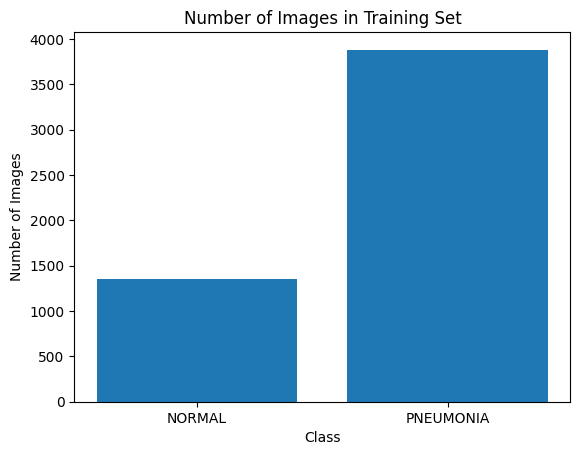

In [18]:
plt.bar(['NORMAL', 'PNEUMONIA'], [len(train_normal_files), len(train_pneumonia_files)])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Training Set')
plt.show()

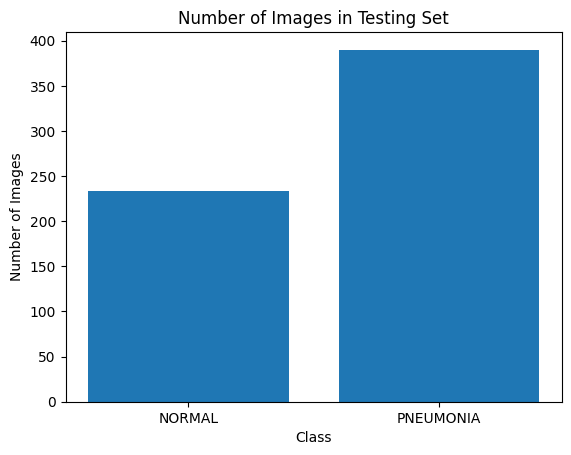

In [19]:
plt.bar(['NORMAL', 'PNEUMONIA'], [len(test_normal_files), len(test_pneumonia_files)])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Testing Set')
plt.show()

Now let's take a look at the images themselves.

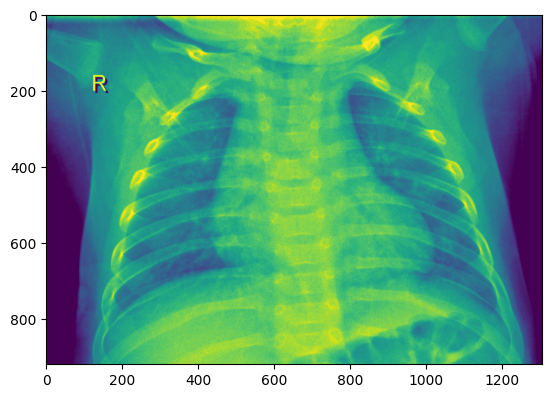

In [20]:
img = np.asarray(Image.open(train_path + '/NORMAL/' + train_normal_files[0]))
imgplot = plt.imshow(img)


Let's put some normal and pneumoia X-Rays side by side.

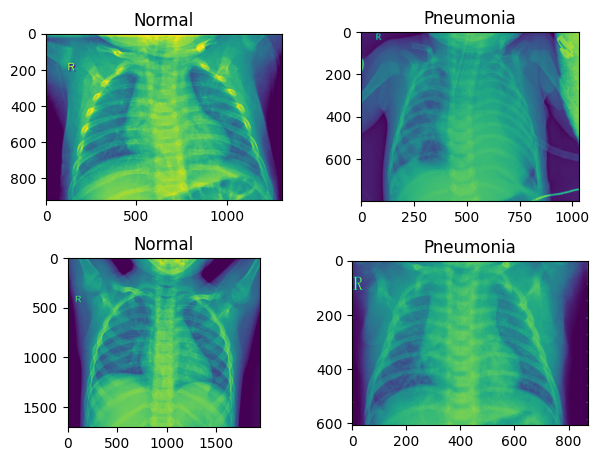

In [21]:
fig, ax = plt.subplots(2,2)
fig.tight_layout(pad=2.0)
ax[0,0].imshow(np.asarray(Image.open(train_path + '/NORMAL/' + train_normal_files[0])))
ax[0,0].set_title('Normal')
ax[0,1].imshow(np.asarray(Image.open(train_path + '/PNEUMONIA/' + train_pneumonia_files[0])))
ax[0,1].set_title('Pneumonia')
ax[1,0].imshow(np.asarray(Image.open(train_path + '/NORMAL/' + train_normal_files[1])))
ax[1,0].set_title('Normal')
ax[1,1].imshow(np.asarray(Image.open(train_path + '/PNEUMONIA/' + train_pneumonia_files[1])))
ax[1,1].set_title('Pneumonia')

plt.show()

Now that we've taken a look at the data. Let's begin builing our CNN models.

# CNN Modeling

A Convolutional Neural Networks is a technique in Deep Learning that is perfect for classification of images. It filters through the images in multiple layers and is able to detect patterns.

To set up the images for analysis we preprocess them first. By normalizing the images, we are able to pass them into the model. In order to reduce overfitting, we will randomly shuffle, shift, and scale the images.

In [50]:
IMG_SIZE = 256
BATCH_SIZE = 64
Channels = 3

In [70]:
data_dir = train_path
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2,
                             width_shift_range=0.2, height_shift_range=0.2,
                             zoom_range=0.2,)
validgen =  ImageDataGenerator(rescale=1./255., validation_split=0.2,
                               width_shift_range=0.2, height_shift_range=0.2,
                               zoom_range=0.2,)
testgen = ImageDataGenerator(rescale=1./255)

random_seed = 10

data_generator = datagen.flow_from_directory(
        directory = data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        subset = "training",
        shuffle=True,
        seed= random_seed,
        class_mode='binary')


valid_generator = validgen.flow_from_directory(
        directory = data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        subset= "validation",
        seed = random_seed,
        class_mode='binary')

test_generator = testgen.flow_from_directory(
        directory = test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        shuffle=False,
        seed= random_seed,
        class_mode='binary')

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In CCN it is important to create a training, validation, and testing group. We have broken the training set into a train and validation group. The validation group consists of 20% of the images in the training group.

Now let’s create a CCN model. The CNN model consists of convolution layers that break down the size of the images by filtering through a 3 X 3 matrix of pixels. We can have multiple convolution layers in order to detect large patterns in the images.

We have 2 convolution layers and are using the Adam optimizer with a learning rate of 0.0001.
Our last layer, the output layer, we are using sigmoid activation, so our output is a number between 0 and 1. This is how we are going to classify between an X-Ray being normal or having pneumonia.


In [62]:
CNN = Sequential()
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, Channels)

CNN.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))

CNN.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool2D(pool_size=(2, 2)))

CNN.add(Flatten())
CNN.add(Dense(units=256, activation='relu'))
CNN.add(BatchNormalization())

CNN.add(Dense(units=1, activation='sigmoid'))


opt = Adam(learning_rate=0.0001)
CNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

CNN.build(input_shape=input_shape)

CNN.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (64, 254, 254, 16)        448       
                                                                 
 batch_normalization_14 (Ba  (64, 254, 254, 16)        64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (64, 127, 127, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (64, 125, 125, 32)        4640      
                                                                 
 batch_normalization_15 (Ba  (64, 125, 125, 32)        128       
 tchNormalization)                                               
                                                      

After we have built the model, now it is time to fit the data to the model. We are going to train the model on the training data, validate it against the validation data, and run it 5 times.

In [63]:
CNN_results = CNN.fit(data_generator, validation_data=valid_generator, epochs=5)

Epoch 1/5
66/66 [==============================] - 107s 2s/step - loss: 0.5209 - accuracy: 0.8068 - val_loss: 0.5342 - val_accuracy: 0.7895
Epoch 2/5
66/66 [==============================] - 105s 2s/step - loss: 0.3217 - accuracy: 0.8909 - val_loss: 0.4712 - val_accuracy: 0.7694
Epoch 3/5
66/66 [==============================] - 105s 2s/step - loss: 0.2854 - accuracy: 0.9085 - val_loss: 0.4813 - val_accuracy: 0.7483
Epoch 4/5
66/66 [==============================] - 106s 2s/step - loss: 0.2555 - accuracy: 0.9171 - val_loss: 0.4092 - val_accuracy: 0.7990
Epoch 5/5
66/66 [==============================] - 105s 2s/step - loss: 0.2335 - accuracy: 0.9245 - val_loss: 0.4876 - val_accuracy: 0.7598


Let's take a look at the results.

In [84]:
CNN_hist = CNN_results.history
CNN_hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [85]:
acc = CNN_results.history['accuracy']
val_acc = CNN_results.history['val_accuracy']
loss = CNN_results.history['loss']
val_loss = CNN_results.history['val_loss']

Now that we have our results, let's plot them.

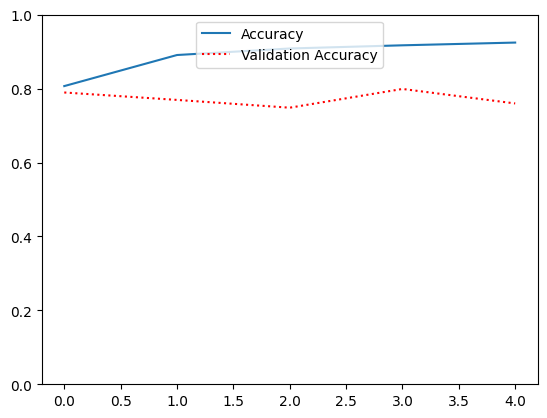

In [66]:
plt.plot(acc,label="Accuracy")
plt.plot(val_acc, linestyle = 'dotted',color = 'r',label="Validation Accuracy")
plt.ylim(0,1)
leg = plt.legend(loc='upper center')
plt.show()

As we can see the accuracy of the model is increasing but the validation accuracy starts to increase then decreases. This could be a sign of overfitting.

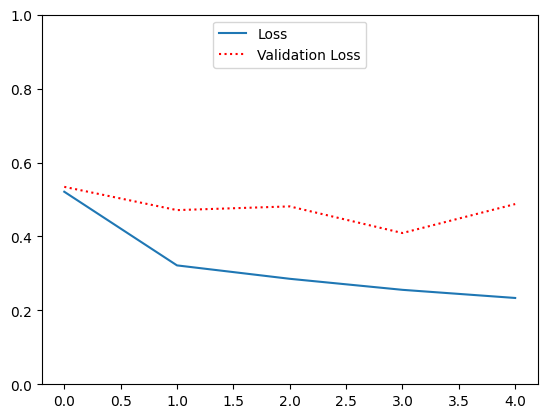

In [67]:
plt.plot(loss,label="Loss")
plt.plot(val_loss, linestyle = 'dotted',color = 'r',label="Validation Loss")
plt.ylim(0,1)
leg = plt.legend(loc='upper center')
plt.show()

As with the accuracy, the loss starts to decrease but then starts to rise. Another indication of overfitting around the 3rd epoch. Let's see how well the model predicts our test data.

In [71]:
score1 = CNN.evaluate(test_generator, steps = len(test_generator), verbose = 1)

624/624 [==============================] - 5s 8ms/step - loss: 0.6929 - accuracy: 0.6282


In [72]:
print('Test loss: ', score1[0])
print('Test accuracy: ', score1[1])

Test loss:  0.6928628087043762
Test accuracy:  0.6282051205635071


As we can see the model predicted 63% of the test data correctly. Let's see if we can improve that accuracy by modifying  our model.

In the second model, we added another convolution layer and addressed some of the overfitting we say in the first model. By adding drop out layers. These dropout layers reduce the number of nodes that are inputting into the next layer to attempt to counter attack over learning.

In [68]:
CNN2 = Sequential()
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, Channels)

CNN2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                kernel_initializer='he_normal',))
CNN2.add(BatchNormalization())
CNN2.add(MaxPool2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.4))

CNN2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(l=0.01)))
CNN2.add(BatchNormalization())
CNN2.add(MaxPool2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.4))

CNN2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN2.add(BatchNormalization())
CNN2.add(MaxPool2D(pool_size=(2, 2)))
CNN2.add(Dropout(0.4))

CNN2.add(Flatten())
CNN2.add(Dense(units=256, activation='relu'))
CNN2.add(BatchNormalization())

CNN2.add(Dropout(0.2))
CNN2.add(Dense(units=1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
CNN2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

CNN2.build(input_shape=input_shape)

CNN2.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (64, 254, 254, 32)        896       
                                                                 
 batch_normalization_17 (Ba  (64, 254, 254, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (64, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_8 (Dropout)         (64, 127, 127, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (64, 125, 125, 32)        9248      
                                                                 
 batch_normalization_18 (Ba  (64, 125, 125, 32)       

Let's fit the model and see the results.

In [69]:
CNN2_results = CNN2.fit(data_generator, validation_data=valid_generator, epochs=5)

Epoch 1/5
66/66 [==============================] - 111s 2s/step - loss: 0.9405 - accuracy: 0.7163 - val_loss: 1.7998 - val_accuracy: 0.7426
Epoch 2/5
66/66 [==============================] - 108s 2s/step - loss: 0.7813 - accuracy: 0.7855 - val_loss: 3.1688 - val_accuracy: 0.7426
Epoch 3/5
66/66 [==============================] - 107s 2s/step - loss: 0.7010 - accuracy: 0.8357 - val_loss: 4.1977 - val_accuracy: 0.7426
Epoch 4/5
66/66 [==============================] - 107s 2s/step - loss: 0.6431 - accuracy: 0.8581 - val_loss: 5.7191 - val_accuracy: 0.7426
Epoch 5/5
66/66 [==============================] - 104s 2s/step - loss: 0.5952 - accuracy: 0.8751 - val_loss: 8.1381 - val_accuracy: 0.7426


In [73]:
CNN_hist = CNN2_results.history
CNN_hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [74]:
acc2 = CNN2_results.history['accuracy']
val_acc2 = CNN2_results.history['val_accuracy']
loss2 = CNN2_results.history['loss']
val_loss2 = CNN2_results.history['val_loss']

Now that we have our results, let's plot them.

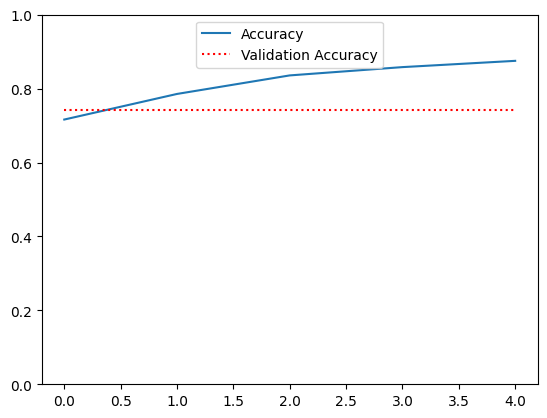

In [75]:
plt.plot(acc2, label="Accuracy")
plt.plot(val_acc2, linestyle = 'dotted',color = 'r',label="Validation Accuracy")
plt.ylim(0,1)
leg = plt.legend(loc='upper center')
plt.show()

The accuracy increases but the validation accuracy stays level. This is a sign that our model is not improving after the first epoch.

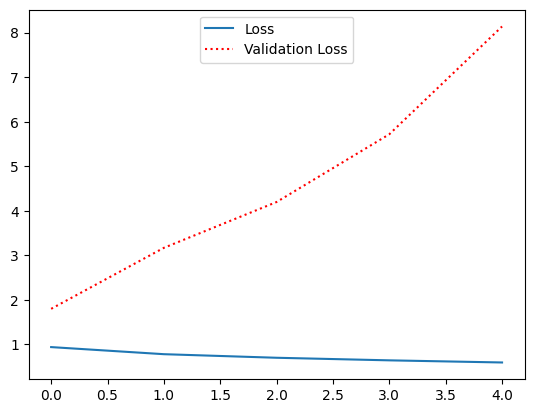

In [76]:
plt.plot(loss2,label="Loss")
plt.plot(val_loss2, linestyle = 'dotted',color = 'r',label="Validation Loss")

leg = plt.legend(loc='upper center')
plt.show()

As we saw in the accuracy graph, our validation loss immediately starts to increase. This is a sure sign of major overfitting. It may be that with the relatively low number of images, CNN models can train on thousands and thousands of images, our more complex model is overfitting right out of the gate.

Let's see how the more complicated model does on the test data.

In [77]:
score2 = CNN2.evaluate(test_generator, steps = len(test_generator), verbose = 1)

624/624 [==============================] - 5s 8ms/step - loss: 10.7898 - accuracy: 0.6250


In [86]:
print('Test loss: ', score2[0])
print('Test accuracy: ', score2[1])


Test loss:  10.78978443145752
Test accuracy:  0.625


The second model has about the same accuracy as our first model but has a much higher loss value. This model may been to complicated for this data set. Let's try to simplify our model but keep our measures to prevent over fitting.

In [81]:
CNN3 = Sequential()
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, Channels)

CNN3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                kernel_initializer='he_normal',))
CNN3.add(BatchNormalization())
CNN3.add(MaxPool2D(pool_size=(2, 2)))
CNN3.add(Dropout(0.4))

CNN3.add(Flatten())
CNN3.add(Dense(units=256, activation='relu'))
CNN3.add(BatchNormalization())

CNN3.add(Dropout(0.2))
CNN3.add(Dense(units=1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)
CNN3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

CNN3.build(input_shape=input_shape)

CNN3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (64, 254, 254, 32)        896       
                                                                 
 batch_normalization_23 (Ba  (64, 254, 254, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (64, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (64, 127, 127, 32)        0         
                                                                 
 flatten_9 (Flatten)         (64, 516128)              0         
                                                                 
 dense_18 (Dense)            (64, 256)                

So now that we have removed some of the convolution layers, we reduced the number of parameters. Let's fit the model to the training data.

In [82]:
CNN3_results = CNN3.fit(data_generator, validation_data=valid_generator, epochs=5)

Epoch 1/5
66/66 [==============================] - 104s 2s/step - loss: 0.5955 - accuracy: 0.7619 - val_loss: 0.4709 - val_accuracy: 0.7512
Epoch 2/5
66/66 [==============================] - 101s 2s/step - loss: 0.4059 - accuracy: 0.8307 - val_loss: 0.5977 - val_accuracy: 0.7426
Epoch 3/5
66/66 [==============================] - 102s 2s/step - loss: 0.3680 - accuracy: 0.8584 - val_loss: 0.4910 - val_accuracy: 0.7569
Epoch 4/5
66/66 [==============================] - 101s 2s/step - loss: 0.3355 - accuracy: 0.8703 - val_loss: 0.4508 - val_accuracy: 0.7608
Epoch 5/5
66/66 [==============================] - 100s 2s/step - loss: 0.2996 - accuracy: 0.8985 - val_loss: 0.3408 - val_accuracy: 0.8220


In [87]:
CNN_hist3 = CNN3_results.history
CNN_hist3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
acc3 = CNN3_results.history['accuracy']
val_acc3 = CNN3_results.history['val_accuracy']
loss3 = CNN3_results.history['loss']
val_loss3 = CNN3_results.history['val_loss']

Let's plot the results.

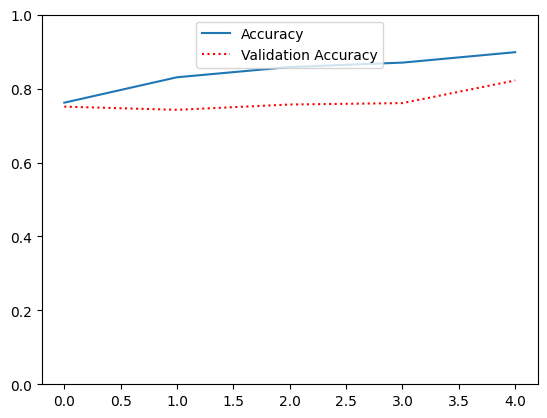

In [89]:
plt.plot(acc3, label="Accuracy")
plt.plot(val_acc3, linestyle = 'dotted',color = 'r',label="Validation Accuracy")
plt.ylim(0,1)
leg = plt.legend(loc='upper center')
plt.show()

So we can see that out accuracy and validation accuracy our both increasing. A better indication than the previous model.

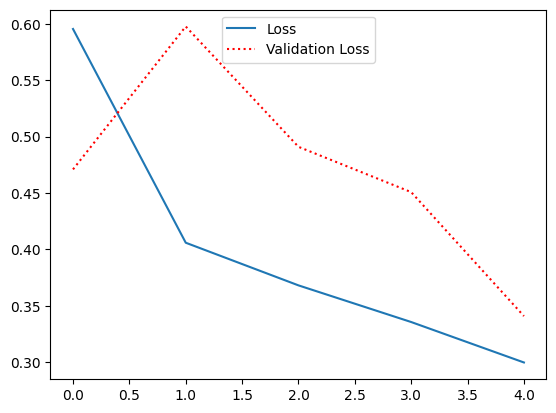

In [90]:
plt.plot(loss3,label="Loss")
plt.plot(val_loss3, linestyle = 'dotted',color = 'r',label="Validation Loss")
leg = plt.legend(loc='upper center')
plt.show()

We see an initial increase in validation loss but the a steady decrease. It looks like we have addressed the overfitting issue. Now let's see how the model does with the test data.

In [91]:
score3 = CNN3.evaluate(test_generator, steps = len(test_generator), verbose = 1)


624/624 [==============================] - 5s 8ms/step - loss: 0.4164 - accuracy: 0.7949


In [104]:
print(f'Test loss: {score3[0]}')
print(f'Test accuracy: {score3[1]}')

Test loss: 0.4163840711116791
Test accuracy: 0.7948718070983887


So, our loss has dramatically decreased and our accuracy is now almost 80%. Let’s compare the models to see how we did.

# Results

In [107]:
test_acc = [score1[1],score2[1],score3[1]]
test_loss = [score1[0],score2[0],score3[0]]

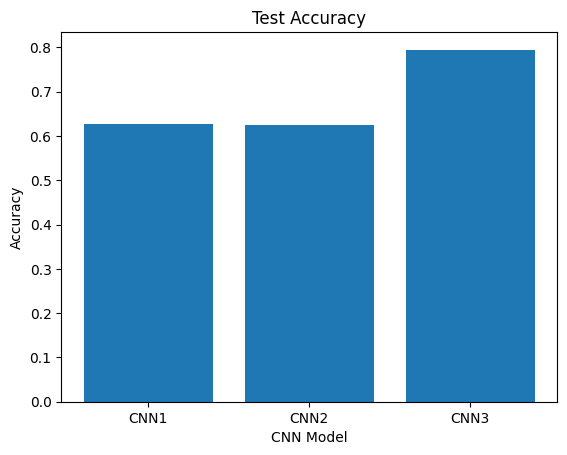

In [103]:
plt.bar(x = ['CNN1', 'CNN2', 'CNN3'], height = test_acc)
plt.title('Test Accuracy')
plt.xlabel('CNN Model')
plt.ylabel('Accuracy')
plt.show()

Our first two models had issues with overfitting. Once addressed we can see that our third model was able to perform more accurately.

Let's take a look at how our validation loss changed over the three models.

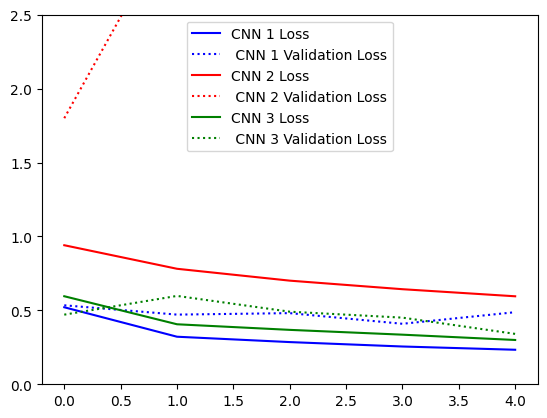

In [110]:
plt.plot(loss,label="CNN 1 Loss",color = 'b')
plt.plot(val_loss, linestyle = 'dotted',color = 'b',label=" CNN 1 Validation Loss")
plt.plot(loss2,label="CNN 2 Loss",color = 'r')
plt.plot(val_loss2, linestyle = 'dotted',color = 'r',label=" CNN 2 Validation Loss")
plt.plot(loss3,label="CNN 3 Loss",color = 'g')
plt.plot(val_loss3, linestyle = 'dotted',color = 'g',label=" CNN 3 Validation Loss")
leg = plt.legend(loc='upper center')
plt.ylim(0,2.5)
plt.show()

Right off the bat, we can see that our second CNN validation loss is skyrocketing. A sure sign that CNN 2 was drastically overfitting. Now when we take a closer look at CNN 1 (no dropouts) and CNN 3 (added dropouts and other normalization layers) at around the fourth epoch, we can see that CNN 3 is continuing to decrease, whereas CNN 1 is starting to rise.


All in all, it looks as if the simpler model with dropouts was the all-around best model.

# Conclusion

We started out with almost 6000 chest X-Ray images. After breaking them into training, validation, and testing groups, we created three CNN models. The first model was simple but had low accuracy, 62%, and should signs of overfitting. In the second model, we added another convolution layer and attempted to address the overfitting problem. But even after we added our dropout layers, the more complicated model overfit even more. On the third model, we took what we learned from the previous two. We added our techniques to address overfitting and applied that to a simpler model. We saw an increase in accuracy, almost up to 80%, and a decrease in the signs of overfitting.

In the future, to address some of the problems in a more complicated model and overfitting, having more images to train on would help. Either through increased data augmentation or by gathering more images, we could see an increase in accuracy and avoid our models learning the training data too well.

# References:



*  https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
*   https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
*   https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/
*   https://medium.com/analytics-vidhya/computer-vision-and-pneumonia-detection-part-1-technical-4e3592de208b



